In [1]:
# Construct Quantile Regression using PyTorch

In [2]:
# import libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [3]:
Bitcoin = pd.read_csv('data/coin_Bitcoin.csv')

In [4]:
## DATA PREPARATION
# Changing Date to appropriate format
Bitcoin["Date"] = pd.to_datetime(Bitcoin["Date"], format='%Y-%m-%d %H:%M:%S')
Bitcoin["Date"] = Bitcoin["Date"].dt.strftime('%Y-%m-%d')
Bitcoin["Date"] = pd.to_datetime(Bitcoin["Date"], format='%Y-%m-%d')
# Bitcoin.info()
# Bitcoin

In [5]:
Bitcoin.set_index("Date", inplace=True)
# Bitcoin

In [6]:
# Getting rid of unnecessary columns
data = Bitcoin.iloc[:, 3:]
# data
# Define features and target
X = data[['High', 'Low', 'Open', 'Volume', 'Marketcap']] # Multivariate
Y = data['Close']

# Normalise - necessary because clearly Volume is much larger than other values
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
# train test split & shuffle
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=5925)
# X_train, X_test, y_train, y_test

In [7]:
# data.info()

In [8]:
# MODEL FITTING - PYTORCH
import torch

In [9]:
# Convert data to PyTorch tensors
# model parameters by default have data type `torch.float32`, so we need to ensure data type is consistent here
X_train_tensor = torch.tensor(X_train, dtype=torch.float32) 
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1) # reshape for nn compatibility
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

/var/folders/lm/0cmy_pz92j91mzfd0b575q0w0000gn/T/ipykernel_95997/2604877086.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1) # reshape for nn compatibility
/var/folders/lm/0cmy_pz92j91mzfd0b575q0w0000gn/T/ipykernel_95997/2604877086.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)


In [10]:
# X_train_tensor.shape, X_test_tensor.shape, y_train_tensor.shape, y_test_tensor.shape

In [11]:
import torch.nn as nn

In [12]:
# Define model
class QuantileRegressionModel(nn.Module):
    def __init__(self, input_dim, output_dim, quantiles): # takes in dimensions and quantiles
        super(QuantileRegressionModel, self).__init__()
        self.quantiles = quantiles
        self.layers = nn.ModuleList([nn.Linear(input_dim, output_dim) for _ in quantiles]) # for loop for different quantiles
        # linear transformation - https://pytorch.org/docs/stable/nn.html#linear-layers
    
    def forward(self, x):
        return torch.cat([layer(x) for layer in self.layers], dim=1) # move all quantile models forward

In [13]:
# Define model parameters
input_dim = X_train.shape[1] # 5 features = High, Low, Open, Volume, Marketcap
output_dim = 1 # Close Price
quantiles = [0.05, 0.25, 0.5, 0.75, 0.95]

In [14]:
# Initialise the model
model = QuantileRegressionModel(input_dim, output_dim, quantiles)

In [15]:
def quantile_loss(predictions, targets, quantiles): # tilted-loss function
    losses = []
    for i, q in enumerate(quantiles):
        errors = targets - predictions[:, i:i+1]
        losses.append(torch.max((q-1) * errors, q * errors).mean())
    return sum(losses)

In [16]:
import torch.optim as optim

In [17]:
# Train the model
optimiser = optim.Adam(model.parameters(), lr=0.01) # Optimiser ADAM, lr = learning rate (play around with values to optimise)
# https://pytorch.org/docs/stable/optim.html

In [35]:
# Training loop
num_epochs = 10000
for epoch in range(num_epochs):
    model.train()
    optimiser.zero_grad()
    
    # Forward pass
    outputs = model(X_train_tensor)
    
    # Compute loss
    loss = quantile_loss(outputs, y_train_tensor, quantiles)
    
    # Backward pass and optimization
    loss.backward()
    optimiser.step()
    
    if (epoch+1) % 1000 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1000/10000], Loss: 16802.8789
Epoch [2000/10000], Loss: 16766.7051
Epoch [3000/10000], Loss: 16730.5312
Epoch [4000/10000], Loss: 16694.3672
Epoch [5000/10000], Loss: 16658.1992
Epoch [6000/10000], Loss: 16622.0352
Epoch [7000/10000], Loss: 16585.8672
Epoch [8000/10000], Loss: 16549.7656
Epoch [9000/10000], Loss: 16513.7090
Epoch [10000/10000], Loss: 16477.9922


In [37]:
# Evaluate the model using the test dataset
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor) # substitute test dataset inputs
    test_loss = quantile_loss(test_outputs, y_test_tensor, quantiles) # calculate test loss by comparing predicted values vs actual values
    print(f'Test Loss: {test_loss.item():.4f}')

# Print test predictions
print("Test Predictions: [0.05, 0.25, 0.5, 0.75, 0.95] percentile")
print(test_outputs)

Test Loss: 16177.7695
Test Predictions: [0.05, 0.25, 0.5, 0.75, 0.95] percentile
tensor([[151.1027, 151.8765, 151.6512, 152.0194, 152.0140],
        [154.2093, 154.9832, 154.7538, 155.1277, 155.1122],
        [151.2690, 152.0444, 151.8194, 152.1892, 152.1800],
        ...,
        [206.3270, 207.0780, 206.7589, 207.1906, 207.0820],
        [484.2419, 484.9800, 484.1034, 484.7915, 484.1688],
        [100.4756, 101.2473, 101.1304, 101.4562, 101.5426]])


In [83]:
# test_outputs.shape

torch.Size([599, 5])

In [ ]:
# y_test_tensor 

In [ ]:
# seems wildly off, but model is somewhat working because it is following similar trend 
'''    Predicted     Actual
Obs 1: 15.5857       8094.3198
Obs 2: 15.8977       8913.4697
Obs 3: 15.6026       8338.3496
...
Obs -3: 21.1240      17429.5000
Obs -2: 48.9142      58803.7773
Obs -1: 10.5271      331.8860
'''

In [39]:
import matplotlib.pyplot as plt
import numpy as np

In [59]:
# Plot the 5 values
predicted_values = test_outputs.numpy() # convert tensor to numpy
# Plot the actual values on the same graph as the predicted values
actual_values = y_test_tensor.numpy()

In [45]:
# quantiles

In [67]:
# Only plot the first 10 values - otherwise scatterplot is too clustered
num_points = 10
index = np.arange(num_points)

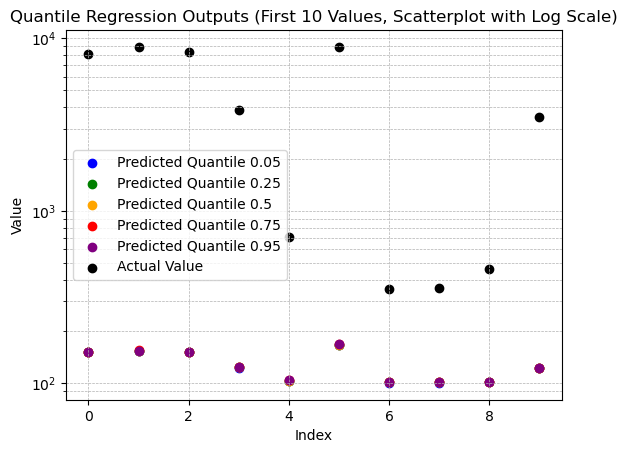

In [71]:
colors = ['blue', 'green', 'orange', 'red', 'purple']
for i, quantile in enumerate(quantiles):
    plt.scatter(index, predicted_values[:num_points, i], color=colors[i], label=f'Predicted Quantile {quantile}') # scatterplot
    # plt.plot(predicted_values[:, i], color=colors[i], label=f'Quantile {quantile}') # line plot

plt.scatter(index, actual_values[:num_points], color = 'black', label = 'Actual Value')

plt.xlabel('Index')
plt.ylabel('Value')
plt.yscale('log')
plt.title('Quantile Regression Outputs (First 10 Values, Scatterplot with Log Scale)')
plt.legend()
plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.show()